# Predicting the Air Quality for next days

* Source: file "P3_WildAir/Open_Meteo_com/OpenMeteo_data/dwl_csv_openmeteo_2124.ipynb";
* source: file "P3 wildAir\p3_WildAir\Open_Meteo_com\OpenMeteo_data\csv_wind4ML.ipynb";
* Each meteo features have the unity measure on title;
* For the wind "u10" and "v10" unities (number means speed):
    - A positive "u" means wind blowing from the West to East (if negative is in the opposing direction);
    - A positive "v" is wind blowing from South to North (if negative...);
* Each pollutant is on micrograms (one-millionth of a gram) per cubic meter air or "µg/m3".
* Machine Learning hybrid model using Random Forest Regressor and Prophet (Meta):
    - Prophet will be trained only with "date" and a given "pollutant" and predicting from temporarie patterns;
    - RFR will be trained with meteo data from 2021 to 2024;
    - FRFProphet will be predicting based on meteo predictions and refining the earlier Prophet predictions;

In [1]:
##### LIBRARIES IN USE #########

##### To get the Open-Meteo data #####
import openmeteo_requests
import requests_cache
from retry_requests import retry

##### Working the Data ######
import pandas as pd
import numpy as np

##### DataViz #####
import matplotlib.pyplot as plt
import seaborn as sns

##### Machine Learning #####
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
#from fbprophet import Prophet


## 1. Getting the Open-Meteo forecast for the next 14 days

### The Open-Meteo forecast: from download to dataframe 

In [19]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 45.7462,
	"longitude": 4.827,
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m", "wind_direction_10m"],
	"timezone": "Europe/Berlin",
	"forecast_days": 14
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)



Coordinates 45.7400016784668°N 4.820000171661377°E
Elevation 170.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
                         date  temperature_2m  relative_humidity_2m  rain  \
0   2025-02-14 23:00:00+00:00           0.952                  72.0   0.0   
1   2025-02-15 00:00:00+00:00           0.652                  71.0   0.0   
2   2025-02-15 01:00:00+00:00           0.852                  68.0   0.0   
3   2025-02-15 02:00:00+00:00           0.202                  72.0   0.0   
4   2025-02-15 03:00:00+00:00          -0.498                  75.0   0.0   
..                        ...             ...                   ...   ...   
331 2025-02-28 18:00:00+00:00           9.086                  66.0   0.0   
332 2025-02-28 19:00:00+00:00           8.536                  69.0   0.0   
333 2025-02-28 20:00:00+00:00           8.036                  71.0   0.0   
334 2025-02-28 21:00:00+00:00           7.736                  73.0   0.0   
335 2025-

### 1.1 Setting up the dataframe

In [20]:
hourly_dataframe.to_csv("df_meteoforecast_14_28fev25.csv", index=False)

In [2]:
df_predict_pm25 = pd.read_csv(r"C:\Users\sophi\FrMarques\LyonData WCS new\P3 wildAir\p3_WildAir\Prediction_final_ML\df_meteoforecast_14_28fev25.csv")

### 1.2 Turning "date" into datetime dtype
* And adding a new "date_only" date without the hours

In [3]:
########## Turn column "date" into "datetime":
df_predict_pm25["date"] = pd.to_datetime(df_predict_pm25["date"])

# Adding a new column just with the date and no hours:
df_predict_pm25["date_only"] = df_predict_pm25["date"].dt.date

### 1.3 Calculatings the daily average for each numerical variable
* And sets a new traditional index

In [4]:
df_predict_pm25 = df_predict_pm25.groupby("date_only").mean().reset_index()

### 1.4 Turning "date_only"/index into datetime dtype

In [118]:
df_predict_pm25["date_only"] = pd.to_datetime(df_predict_pm25["date_only"])

### 1.5 Dropping unnecessary column

In [119]:
df_predict_pm25 = df_predict_pm25.drop(columns="date")

### 1.6 Renaming the columns/features

In [120]:
df_predict_pm25 = df_predict_pm25.rename(columns={
    "date_only": "date_id",
    "temperature_2m": "temp_c",
    "relative_humidity_2m": "humidity_%",
    "rain": "rain_mm",
    "snowfall": "snowfall_cm",
    "surface_pressure": "atmopressure_hpa",
    "cloud_cover": "cloudcover_%",
    "wind_speed_10m": "windspeed_kmh",
    "wind_direction_10m": "winddirection_360"
    })

### 1.7 Setting the "date-id" as the index

In [121]:
df_predict_pm25.set_index('date_id', inplace=True)

### 1.8 Creating wind features usable by the ML

In [122]:
df_predict_pm25["windspeed_ms"] = df_predict_pm25["windspeed_kmh"] * 0.277778   # turning speed from km/h to m/s;
wind_dir_rad = np.radians(df_predict_pm25["winddirection_360"])                   # turning direction to radians;
df_predict_pm25["u10"] = -df_predict_pm25["windspeed_ms"] * np.sin(wind_dir_rad)   # calculating "u" and "v";
df_predict_pm25["v10"] = -df_predict_pm25["windspeed_ms"] * np.cos(wind_dir_rad)

### 1.9 Droping unnecessary wind features

In [123]:
columns2drop = ["windspeed_ms", "windspeed_kmh", "winddirection_360"]

df_predict_pm25 = df_predict_pm25.drop(columns=columns2drop)

In [135]:
df_predict_pm25.head(2)

,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
date_id,,,,,,,,
2025-02-14,0.9520,72.00,0.0,0.0,1001.49760,0.000000,2.100005,-1.899998
2025-02-15,1.8145,67.25,0.0,0.0,998.68566,36.958333,0.272833,1.006401


In [ ]:
df_predict_pm25.to_csv("df_meteo_14_28fev2025.csv")

In [32]:
print(df_predict_pm25.shape)
display(df_predict_pm25.head(2))
display(df_predict_pm25.sample(2))
display(df_predict_pm25.tail(2))

(15, 8)


,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
date_id,,,,,,,,
2025-02-14,0.9520,72.00,0.0,0.0,1001.49760,0.000000,2.100005,-1.899998
2025-02-15,1.8145,67.25,0.0,0.0,998.68566,36.958333,0.272833,1.006401


,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
date_id,,,,,,,,
2025-02-24,9.6610,87.250000,0.133333,0.0,1005.618386,99.666667,-0.014809,2.237744
2025-02-21,10.6705,70.416667,0.000000,0.0,1005.885250,9.125000,-1.119322,4.362220


,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
date_id,,,,,,,,
2025-02-27,9.300583,79.791667,0.291667,0.0,993.002606,100.000000,0.989340,3.823775
2025-02-28,7.838174,74.086957,0.034783,0.0,993.874783,65.869565,0.498153,2.003815


## 2. Getting the pollutants dataframe 2021-2024
* To be used in the Prophet training

In [14]:
df_polluant_GA2124 = pd.read_csv(r"C:\Users\sophi\FrMarques\LyonData WCS new\P3 wildAir\p3_WildAir\Open_Meteo_com\OpenMeteo_data\CSV\CSV_polluant2124\df_polluants_21_24.csv", sep=";")

In [15]:
df_polluant_GA2124["Date"] = pd.to_datetime(df_polluant_GA2124["Date"])
df_polluant_GA2124 = df_polluant_GA2124.rename(columns={
    "Date": "date_id",
    "NO2": "no2",
    "O3": "o3",
    "PM10": "pm10",
    "PM2.5": "pm2.5",
    "SO2": "so2"
})

In [16]:
print(df_polluant_GA2124.shape)
display(df_polluant_GA2124.head(3))

(1461, 6)


,date_id,no2,o3,pm10,pm2.5,so2
0,2021-01-01,71.0,58.3,24.2,24.2,8.1
1,2021-01-02,46.0,49.8,23.2,16.4,31.4
2,2021-01-03,77.5,49.8,57.3,55.9,4.7


## 3. Training the Prophet model
* And saving the forecasts for the 14 days after the last historic date it has available and that is not good for our project.

In [9]:
# # 🟢 1️⃣ Carregar os dados históricos de poluentes (2021-2024)
# df_poluentes = pd.read_csv("dados_poluentes_2021_2024.csv")

# Preparing to get forecasts from Prophet for each pollutant:
pollutants = ["no2", "o3", "pm10", "pm2.5", "so2"]
forecast_prophet = {}

for pollutant in pollutants:
    print(f"Training Prophet for {pollutant}")
    
    # Creating a dataset with the Prophet structure:
    df_prophet = df_polluant_GA2124[["date_id", pollutant]].rename(columns={"date_id": "ds", pollutant: "y"})
    
    # Creating and training the Prophet:
    model_p = Prophet(yearly_seasonality=True, weekly_seasonality=True,daily_seasonality=False)
    model_p.fit(df_prophet)
    
    # Make predictions for the next 14 days
    future_p = model_p.make_future_dataframe(periods=14)
    forecast_p = model_p.predict(future_p)
    
    # Saving 14 predictions in the dictionairy:
    forecast_prophet[pollutant] = forecast_p[["ds", "yhat"]].tail(14)

Training Prophet for no2


20:41:34 - cmdstanpy - INFO - Chain [1] start processing
20:41:35 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet for o3


20:41:36 - cmdstanpy - INFO - Chain [1] start processing
20:41:36 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet for pm10


20:41:37 - cmdstanpy - INFO - Chain [1] start processing
20:41:37 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet for pm2.5


20:41:38 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet for so2


20:41:40 - cmdstanpy - INFO - Chain [1] start processing
20:41:40 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Exibir previsões do Prophet para cada poluente
for poluente, previsao in forecast_prophet.items():
    print(f"Previsões do Prophet para {poluente}:")
    print(previsao.tail())  # Mostrar os últimos valores previstos
    print("\n" + "-"*50 + "\n")


Previsões do Prophet para no2:
             ds       yhat
1470 2025-01-10  67.218477
1471 2025-01-11  58.363117
1472 2025-01-12  57.700661
1473 2025-01-13  64.293735
1474 2025-01-14  67.662051

--------------------------------------------------

Previsões do Prophet para o3:
             ds       yhat
1470 2025-01-10  41.668214
1471 2025-01-11  39.677281
1472 2025-01-12  41.385196
1473 2025-01-13  39.286713
1474 2025-01-14  38.462210

--------------------------------------------------

Previsões do Prophet para pm10:
             ds       yhat
1470 2025-01-10  51.259143
1471 2025-01-11  38.633856
1472 2025-01-12  38.482836
1473 2025-01-13  46.117742
1474 2025-01-14  53.376587

--------------------------------------------------

Previsões do Prophet para pm2.5:
             ds       yhat
1470 2025-01-10  34.712856
1471 2025-01-11  34.357324
1472 2025-01-12  33.857360
1473 2025-01-13  34.225102
1474 2025-01-14  35.043696

--------------------------------------------------

Previsões do P

#### Conclusion:
* Prophet is only able to predict pollution levels from the latest historic temporary date. The model only predicts using seasonality patterns and showed being limited to be used in the WildAir project. 

## 4. Preparing data for the optimized RandomForestRegressor
* The first meteo forecast dataset and the training set merging meteo and pollutants levels between 2021-2024

In [41]:
display(df_predict_pm25.head(2))
# df_polluant_GA2124.set_index("date_id", inplace=True)
display(df_polluant_GA2124.head(2))

,date_id,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
0,2025-02-14,0.9520,72.00,0.0,0.0,1001.49760,0.000000,2.100005,-1.899998
1,2025-02-15,1.8145,67.25,0.0,0.0,998.68566,36.958333,0.272833,1.006401


,date_id,no2,o3,pm10,pm2.5,so2
0,2021-01-01,71.0,58.3,24.2,24.2,8.1
1,2021-01-02,46.0,49.8,23.2,16.4,31.4


### 4.1 Getting the training set of data: meteo and pollutants 2021-2024
* source: "P3 wildAir\p3_WildAir\Open_Meteo_com\OpenMeteo_data\CSV\CSV_meteopollu_final\meteopolluwind2124_final.csv"


In [5]:
df_metepollu_trainingset = pd.read_csv(r"C:\Users\sophi\FrMarques\LyonData WCS new\P3 wildAir\p3_WildAir\Open_Meteo_com\OpenMeteo_data\CSV\CSV_meteopollu_final\meteopolluwind2124_final.csv")

### 4.2 Deleting unecessary columns and reorganizing the saved ones

In [6]:
df_metepollu_trainingset = df_metepollu_trainingset[['date_id', 'month_num', 'temp_c', \
    'humidity_%', 'rain_mm', 'snowfall_cm', 'atmopressure_hpa', 'cloudcover_%', 'u10', 'v10', \
       'NO2', 'O3', 'PM10', 'PM2.5', 'SO2']]

### 4.3 Setting "date_id" as "datetime" dtype index

In [7]:
df_metepollu_trainingset = df_metepollu_trainingset.copy()
df_metepollu_trainingset["date_id"] = pd.to_datetime(df_metepollu_trainingset["date_id"])
df_metepollu_trainingset.set_index("date_id", inplace=True)

### 4.4 Renaming the labels all to minuscules

In [8]:
df_metepollu_trainingset = df_metepollu_trainingset.rename(columns={
    "NO2": "no2",
    "O3": "o3",
    "PM10": "pm10",
    "PM2.5": "pm2.5",
    "SO2": "so2"
    })

In [30]:
df_metepollu_trainingset.to_csv("df_metepollu_trainingset2124.csv")

In [9]:
print(df_metepollu_trainingset.shape)
display(df_metepollu_trainingset.head(2))
display(df_metepollu_trainingset.sample(2))
display(df_metepollu_trainingset.tail(2))

(1461, 14)


,month_num,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10,no2,o3,pm10,pm2.5,so2
date_id,,,,,,,,,,,,,,
2021-01-01,1,2.599667,85.773796,0.075000,0.002917,988.10660,95.291664,1.368064,-3.283859,71.0,58.3,24.2,24.2,8.1
2021-01-02,1,1.618417,79.047424,0.008333,0.023333,989.22394,95.791664,2.309296,-5.272886,46.0,49.8,23.2,16.4,31.4


,month_num,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10,no2,o3,pm10,pm2.5,so2
date_id,,,,,,,,,,,,,,
2024-09-08,9,19.108000,79.973946,0.437500,0.0,992.116400,72.791664,0.935445,1.168814,56.6,67.5,18.6,16.1,1.6
2022-11-21,11,7.560333,87.208333,0.158333,0.0,986.501006,98.000000,0.595681,2.469616,72.9,45.6,37.1,18.9,7.7


,month_num,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10,no2,o3,pm10,pm2.5,so2
date_id,,,,,,,,,,,,,,
2024-12-30,12,-1.24825,94.168620,0.0,0.0,1012.07794,100.000000,0.601134,0.123271,64.9,23.0,40.7,25.6,8.6
2024-12-31,12,-0.81700,89.934456,0.0,0.0,1011.63837,61.708332,-0.142459,0.503723,70.2,6.6,49.0,38.3,3.3


## 5. Training and testing the RandomForestRegressor
* With a sliding window of 3 days 

### 5.1 Working code to optimize RFR

In [1]:
df_rfr_train = df_metepollu_trainingset.copy()  # using a special "df" for ML, saving the original;

window_size = 3         # setting a "windo size" of a 3 days period
for i in range (1, window_size + 1):
    for pollutant in ["no2", "o3", "pm10", "pm2.5", "so2"]:
        df_rfr_train[f"{pollutant}_t-{i}"] = df_rfr_train[pollutant].shift(i)   # adding new columns with 3 last days pollutant data for each day;

df_rfr_train = df_rfr_train.dropna().copy()     # as the 3 first rows/dates got some "nan", we drop those 1st lines
                                                #.... leaving the train dataframe with less 3 rows;


X = df_rfr_train.drop(columns=["month_num", "no2", "o3", "pm10", "pm2.5", "so2"]) # team features (just meteo);
y_dict = {pollutant: df_rfr_train[pollutant] for pollutant in ["no2", "o3", "pm10", "pm2.5", "so2"]} # team target;

X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {} # Train_Test_Split

for pollutant in y_dict:
    X_train[pollutant], X_test[pollutant], y_train_dict[pollutant], y_test_dict[pollutant] = train_test_split(
        X, y_dict[pollutant], test_size=0.2, random_state=42
    )

best_params = {
    "n_estimators": 100,        # number of decision trees after a gridsearchCV with 50 and 100;
    "max_depth": 15,            # best max depth from 10 or 20 to feel patterns and avoid overfitting;
    "min_samples_split": 5,     # best samples_split from 2 or 5 (still not cleared);
    "min_samples_leaf": 5,     # best samplesleaf from a suggested 5 to improve generalization of results;
    "random_state": 42          # ensuring the samples stays the same and results to be comparable during tests;
}

rfr_models = {}                 # Preparing a model for each pollutant;
metrics = {}                    # Preparing metrics to evaluatre results on each pollutant;

for pollutant in y_train_dict:  # Training the RFR with the best_params for each pollutant;
    print(f"Training RFR for {pollutant}")
    
    rfr = RandomForestRegressor(**best_params)
    rfr.fit(X_train[pollutant], y_train_dict[pollutant])
    
    rfr_models[pollutant] = rfr
    
    y_pred = rfr.predict(X_test[pollutant]) # predicting target (y) from the test X team;
    
    mae = mean_absolute_error(y_test_dict[pollutant], y_pred)
    mse = mean_squared_error(y_test_dict[pollutant], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_dict[pollutant], y_pred)
    
    metrics[pollutant] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("\n How good is the RFR model: ")
for pollutant, values in metrics.items():
    print(f"\n - predicting {pollutant}")
    for metric, value in values.items():
        print(f"{metric}: {value:.2f}")

NameError: name 'df_metepollu_trainingset' is not defined

#### Conclusions:
* Overall, the results are not brilliant but they are terrible for the PM10, as it should be affected by extreme outliers that we can notice in the following ".describe()": more than 972 µg/m3 as max value;

In [ ]:
df_metepollu_trainingset[["no2", "o3", "pm10", "pm2.5", "so2"]].describe()

,no2,o3,pm10,pm2.5,so2
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,81.040999,72.644969,45.523682,21.719986,18.653703
std,24.201867,28.317610,40.249657,12.981523,29.012151
min,5.200000,3.300000,11.900000,3.000000,-2.900000
25%,66.000000,55.300000,28.100000,13.500000,3.000000
50%,80.700000,73.500000,38.300000,17.700000,7.900000
75%,95.300000,90.200000,53.600000,25.500000,22.700000
max,164.400000,184.700000,972.300000,115.100000,283.300000


### 5.2. Dealing with PM10 ouliers

#### 5.2.1. Setting the IQR for "pm10" to identify and drop the outliers

In [ ]:
Q1 = df_metepollu_trainingset["pm10"].quantile(0.25)    # Getting the boundaries for outliers by the IQR method;
Q3 = df_metepollu_trainingset["pm10"].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR    # Getting the upper and lower boundaries and identify outliers
upper_limit = Q3 + 1.5 * IQR

df_pm10_clean = df_metepollu_trainingset[(df_metepollu_trainingset["pm10"] >= lower_limit) & 
                                         (df_metepollu_trainingset["pm10"] <= upper_limit)] # droping ouliers;

df_outliers = df_metepollu_trainingset[(df_metepollu_trainingset["pm10"] < lower_limit) | 
                                       (df_metepollu_trainingset["pm10"] > upper_limit)]
print(f"Values before outliers cleaning: {df_metepollu_trainingset.shape[0]}")
print(f"Values without outliers: {df_pm10_clean.shape[0]}")     # checking how much data we discarded;
print(f"We droped '{(df_metepollu_trainingset.shape[0]) - (df_pm10_clean.shape[0])}' outliers")
print(df_outliers["pm10"].describe())


Values before outliers cleaning: 1461
Values without outliers: 1385
We droped '76' outliers
count     76.000000
mean     141.367105
std      129.803762
min       92.200000
25%       99.100000
50%      112.600000
75%      132.325000
max      972.300000
Name: pm10, dtype: float64


#### 5.2.2. Applying RFR model to the new set of "pm10" data

In [ ]:
X_pm10_clean = df_pm10_clean.drop(columns=["month_num", "no2", "o3", "pm10", "pm2.5", "so2"])
y_pm10_clean = df_pm10_clean["pm10"]

X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(
    X_pm10_clean, y_pm10_clean, test_size=0.2, random_state=42
)

best_params_pm10 = {
    "n_estimators": 50,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 15,  # revising on up the leaf/external nodes samples;
    "random_state": 42
}

rfr_pm10 = RandomForestRegressor(**best_params_pm10)
rfr_pm10.fit(X_train_pm10, y_train_pm10)

y_pred_pm10 = rfr_pm10.predict(X_test_pm10)

mae_pm10 = mean_absolute_error(y_test_pm10, y_pred_pm10)
mse_pm10 = mean_squared_error(y_test_pm10, y_pred_pm10)
rmse_pm10 = np.sqrt(mse_pm10)
r2_pm10 = r2_score(y_test_pm10, y_pred_pm10)

print("PM10 results after removing outliers and adjusting RFR model:")
print(f"   - MAE: {mae_pm10:.2f}")
print(f"   - MSE: {mse_pm10:.2f}")
print(f"   - RMSE: {rmse_pm10:.2f}")
print(f"   - R2: {r2_pm10:.2f}")


PM10 results after removing outliers and adjusting RFR model:
   - MAE: 11.07
   - MSE: 190.31
   - RMSE: 13.80
   - R2: 0.27


#### 5.2.3. Rechecking meteo correlations with the now clean pm10:

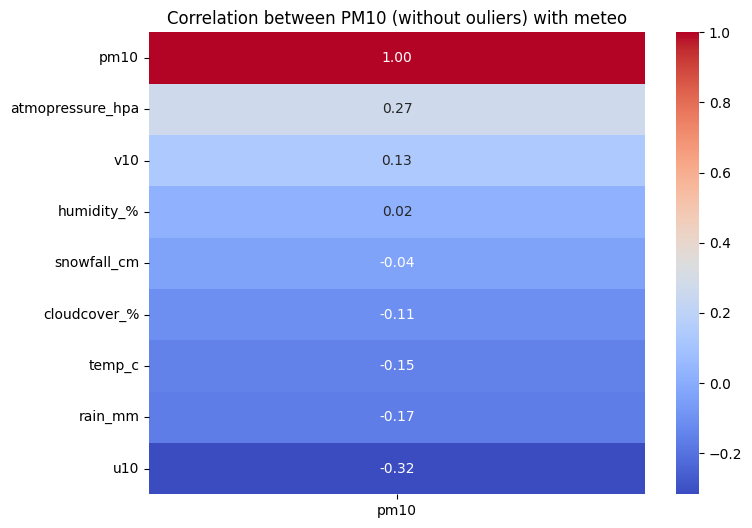

In [ ]:
meteo_columns = ["temp_c", "humidity_%", "rain_mm", "snowfall_cm",  #only meteo columns for correlation;
                 "atmopressure_hpa", "cloudcover_%", "u10", "v10"]

corr_matrix_pm10 = df_pm10_clean[meteo_columns + ["pm10"]].corr()   # setting the correlation between meteo and pm10;

plt.figure(figsize=(8, 6))      # visualizing the correlations;
sns.heatmap(corr_matrix_pm10[["pm10"]].sort_values(by="pm10", ascending=False), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between PM10 (without ouliers) with meteo")
plt.show()



#### 5.2.4. Retesting RFR on pm10 without "snow" and "humidity" 

In [ ]:
vars_to_keep = ["temp_c", "rain_mm", "atmopressure_hpa", "cloudcover_%", "u10", "v10"]

X_pm10_filtered = df_pm10_clean[vars_to_keep]

X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(
    X_pm10_filtered, y_pm10_clean, test_size=0.2, random_state=42
)

best_params_pm10 = {
    "n_estimators": 50,
    "max_depth": 15,
    "min_samples_split": 2,
    "min_samples_leaf": 5,
    "random_state": 42
}

rfr_pm10_filtered = RandomForestRegressor(**best_params_pm10)
rfr_pm10_filtered.fit(X_train_pm10, y_train_pm10)

y_pred_pm10_filtered = rfr_pm10_filtered.predict(X_test_pm10)

mae_pm10_filtered = mean_absolute_error(y_test_pm10, y_pred_pm10_filtered)
mse_pm10_filtered = mean_squared_error(y_test_pm10, y_pred_pm10_filtered)
rmse_pm10_filtered = np.sqrt(mse_pm10_filtered)
r2_pm10_filtered = r2_score(y_test_pm10, y_pred_pm10_filtered)

print("\n PM10 results after otimized features:")
print(f"   - MAE: {mae_pm10_filtered:.2f}")
print(f"   - MSE: {mse_pm10_filtered:.2f}")
print(f"   - RMSE: {rmse_pm10_filtered:.2f}")
print(f"   - R2: {r2_pm10_filtered:.2f}")


 PM10 results after otimized features:
   - MAE: 10.90
   - MSE: 186.84
   - RMSE: 13.67
   - R2: 0.28


## 6. Testing GradientBoostingRegressor model
* Just to check if it brings significant improvements

In [96]:
gbr_params = {              # GBR special params;
    "n_estimators": 100,    # number of decising trees; 
    "learning_rate": 0.1,   # how much a tree works fot the results;
    "max_depth": 5,         # Maximal depth for each tree;
    "min_samples_leaf": 10, # Minimum samples for each leaf/ end node;
    "random_state": 42
}

gbr_pm10 = GradientBoostingRegressor(**gbr_params)
gbr_pm10.fit(X_train_pm10, y_train_pm10)

y_pred_gbr = gbr_pm10.predict(X_test_pm10)

mae_gbr = mean_absolute_error(y_test_pm10, y_pred_gbr)
mse_gbr = mean_squared_error(y_test_pm10, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test_pm10, y_pred_gbr)

print("\n PM10 with Gradient Boosting:")
print(f"   - MAE: {mae_gbr:.2f}")
print(f"   - MSE: {mse_gbr:.2f}")
print(f"   - RMSE: {rmse_gbr:.2f}")
print(f"   - R2: {r2_gbr:.2f}")



 PM10 with Gradient Boosting:
   - MAE: 10.98
   - MSE: 188.18
   - RMSE: 13.72
   - R2: 0.28


* Not a great improvement so we'll stick with the RFR.

## 7. The final RFR model

In [10]:
df_rfr_train_all = df_metepollu_trainingset.drop(columns=["pm10"]).copy()  # Copy of the df to be used in the final RFR model; 

df_rfr_train_pm10 = df_metepollu_trainingset[df_metepollu_trainingset["pm10"] < 92.2].copy()  # df pm10 without outliers;
df_rfr_train_pm10 = df_rfr_train_pm10.drop(columns=["no2", "o3", "pm2.5", "so2"])  # Remove other pollutants;

window_size = 3         # setting the sliding window;
for i in range(1, window_size + 1):
    for pollutant in ["no2", "o3", "pm2.5", "so2"]:  # just for "df ALL";
        df_rfr_train_all[f"{pollutant}_t-{i}"] = df_rfr_train_all[pollutant].shift(i)
        
    df_rfr_train_pm10[f"pm10_t-{i}"] = df_rfr_train_pm10["pm10"].shift(i)  # just for "df pm10";

df_rfr_train_all.dropna(inplace=True)       # remove 3 lines with the "nan" generated by the sliding windows;
df_rfr_train_pm10.dropna(inplace=True)

X_all = df_rfr_train_all.drop(columns=["month_num", "no2", "o3", "pm2.5", "so2"])   # set the features;
y_dict_all = {pollutant: df_rfr_train_all[pollutant] for pollutant in ["no2", "o3", "pm2.5", "so2"]}    # set the targets;

X_pm10 = df_rfr_train_pm10.drop(columns=["month_num", "pm10",]) # set the features for "pm10"
y_pm10 = df_rfr_train_pm10["pm10"]                              # set the pm10 as target;

X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {} # spliting the teams for train and test;
for pollutant in y_dict_all:
    X_train[pollutant], X_test[pollutant], y_train_dict[pollutant], y_test_dict[pollutant] = train_test_split(
        X_all, y_dict_all[pollutant], test_size=0.2, random_state=42
    )

X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(    # spliting the teams for "df pm10";
    X_pm10, y_pm10, test_size=0.2, random_state=42
)

best_params_pm10 = {                # setting the best hyperparameters; 
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 2,
    "min_samples_leaf": 5,
    "random_state": 42
}

best_params_others = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 10,
    "random_state": 42
}

rfr_models = {}                 # Opening dictionaires to receive the trained models
metrics = {}

print(f"Training RFR for PM10 (cleaned dataset)")
rfr_pm10 = RandomForestRegressor(**best_params_pm10)    # training the model to learn about pm10;
rfr_pm10.fit(X_train_pm10, y_train_pm10)
rfr_models["pm10"] = rfr_pm10

y_pred_pm10 = rfr_pm10.predict(X_test_pm10)             # testing pm10 predictions; 
mae_pm10 = mean_absolute_error(y_test_pm10, y_pred_pm10)
mse_pm10 = mean_squared_error(y_test_pm10, y_pred_pm10)
rmse_pm10 = np.sqrt(mse_pm10)
r2_pm10 = r2_score(y_test_pm10, y_pred_pm10)
metrics["pm10"] = {"MAE": mae_pm10, "MSE": mse_pm10, "RMSE": rmse_pm10, "R2": r2_pm10}

for pollutant in y_train_dict:                          # training the model for the other pollutants;
    print(f"Training RFR for {pollutant}")
    
    rfr = RandomForestRegressor(**best_params_others)
    rfr.fit(X_train[pollutant], y_train_dict[pollutant])
    
    rfr_models[pollutant] = rfr
    
    y_pred = rfr.predict(X_test[pollutant])             # Testing predictions for other pollutants;
    
    mae = mean_absolute_error(y_test_dict[pollutant], y_pred)
    mse = mean_squared_error(y_test_dict[pollutant], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_dict[pollutant], y_pred)
    
    metrics[pollutant] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("\n Final RFR model performance:")
for pollutant, values in metrics.items():
    print(f"\n* Predicting {pollutant}:")
    for metric, value in values.items():
        print(f"   {metric}: {value:.2f}")


Training RFR for PM10 (cleaned dataset)
Training RFR for no2
Training RFR for o3
Training RFR for pm2.5
Training RFR for so2

 Final RFR model performance:

* Predicting pm10:
   MAE: 10.36
   MSE: 164.53
   RMSE: 12.83
   R2: 0.30

* Predicting no2:
   MAE: 14.16
   MSE: 328.20
   RMSE: 18.12
   R2: 0.46

* Predicting o3:
   MAE: 10.35
   MSE: 193.65
   RMSE: 13.92
   R2: 0.76

* Predicting pm2.5:
   MAE: 6.11
   MSE: 88.98
   RMSE: 9.43
   R2: 0.47

* Predicting so2:
   MAE: 12.75
   MSE: 555.58
   RMSE: 23.57
   R2: 0.22


## 8. Pollution Prediction Model Function

In [12]:
def predict_pollution(forecast_meteo, trained_models):
    """
    Function to forecast pollution levels from meteo forecast data.

    Parameters:
    - forecast_meteo (DataFrame): DataFrame with meteo forecast.
    - trained_models (dict): Dictionary with trained models{pollutant: correspondent RFR model}.

    Returns:
    - df_predictions (DataFrame): DataFrame with forecast for each pollutant.
    """
    
    df_predictions = forecast_meteo[["date_id"]].copy()     # sets a dataframe to save the predictions;

    forecast_meteo = forecast_meteo.drop(columns=["date_id"], errors="ignore")  # remove unecessary columns;

    for pollutant, model in trained_models.items():     # generates forecasts for each pollutant with
        print(f" Making prediction for {pollutant}...")   #...  the correspondent model;
        df_predictions[f"{pollutant}_Predicted"] = model.predict(forecast_meteo)

    return df_predictions

#  **Example of function use **:
# forecast_meteo = pd.read_csv("forecast_meteo_14days.csv")  # Replace by the dataset with meteo forecasts;
# df_results = predict_pollution(forecast_meteo, rfr_models)
# print(df_results)


* The function needs a dataframe with meteo forecasts but also requests the ML model which it wasn't suppose;
* I'm trying to understand how to have the trained ML model included in the function just to for the user to give it the prepared meteo forecasts as a dataframe and get in return another dataframe with the forecast for each pollutant;

In [13]:

df_train = df_metepollu_trainingset.copy()
features = ['temp_c', 'humidity_%', 'rain_mm', 'snowfall_cm',
            'atmopressure_hpa', 'cloudcover_%', 'u10', 'v10']

pollutants = ["no2", "o3", "pm10", "pm2.5", "so2"]

X = df_train[features]
y_dict = {pollutant: df_train[pollutant] for pollutant in pollutants}

X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}

for pollutant in pollutants:
    X_train[pollutant], X_test[pollutant], y_train_dict[pollutant], y_test_dict[pollutant] = train_test_split(
        X, y_dict[pollutant], test_size=0.2, random_state=42
    )

best_params = {
    "n_estimators": 100,  
    "max_depth": 15,      
    "min_samples_split": 2,  
    "min_samples_leaf": 5,  
    "random_state": 42  
}

rfr_models = {}  
metrics = {}  

for pollutant in pollutants:
    print(f" Training the RFR for {pollutant}...")

    rfr = RandomForestRegressor(**best_params)
    rfr.fit(X_train[pollutant], y_train_dict[pollutant])

    rfr_models[pollutant] = rfr  

    y_pred = rfr.predict(X_test[pollutant])  

    mae = mean_absolute_error(y_test_dict[pollutant], y_pred)
    mse = mean_squared_error(y_test_dict[pollutant], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_dict[pollutant], y_pred)

    metrics[pollutant] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("\n Evaluating the final model:")

for pollutant, values in metrics.items():
    print(f"\n {pollutant}:")
    for metric, value in values.items():
        print(f"   -{metric}: {value:.2f}")

def predict_pollution(forecast_meteo, trained_models):
    """
    Function to forecast pollution levels from meteo forecasts.

    Parameters:
    - forecast_meteo (DataFrame): DataFrame with meteo forecasts.
    - trained_models (dict): Dictionary with the trained models {pollutant: correspondent model}.

    Returns:
    - df_predictions (DataFrame): DataFrame with forecasts for each pollutant.
    """
    
    df_predictions = forecast_meteo[["date_id"]].copy()

    forecast_meteo = forecast_meteo.drop(columns=["date_id"], errors="ignore")

    for pollutant, model in trained_models.items():
        print(f" Calculating a forecast for {pollutant}...")
        df_predictions[f"{pollutant}_Predicted"] = model.predict(forecast_meteo)

    return df_predictions

# 🟢 8️⃣ Example of use:
# forecast_meteo = pd.read_csv("forecast_meteo_14days.csv")  
# df_results = predict_pollution(forecast_meteo, rfr_models)
# print(df_results)


 Training the RFR for no2...
 Training the RFR for o3...
 Training the RFR for pm10...
 Training the RFR for pm2.5...
 Training the RFR for so2...

 Evaluating the final model:

 no2:
   -MAE: 14.15
   -MSE: 328.02
   -RMSE: 18.11
   -R2: 0.34

 o3:
   -MAE: 12.35
   -MSE: 269.02
   -RMSE: 16.40
   -R2: 0.68

 pm10:
   -MAE: 16.24
   -MSE: 669.24
   -RMSE: 25.87
   -R2: -0.10

 pm2.5:
   -MAE: 6.60
   -MSE: 97.23
   -RMSE: 9.86
   -R2: 0.47

 so2:
   -MAE: 12.57
   -MSE: 487.78
   -RMSE: 22.09
   -R2: 0.31


### 8.1 First prediction
* 

In [18]:
forecast_meteo = pd.read_csv(r"C:\Users\sophi\FrMarques\LyonData WCS new\P3 wildAir\p3_WildAir\Prediction_final_ML\CSV to predict\df_meteo_14_28fev2025.csv")
forecast_meteo.head(1)

,date_id,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
0,2025-02-14,0.952,72.0,0.0,0.0,1001.4976,0.0,2.100005,-1.899998


In [128]:
forecast_meteo.columns

Index(['date_id', 'temp_c', 'humidity_%', 'rain_mm', 'snowfall_cm',
       'atmopressure_hpa', 'cloudcover_%', 'u10', 'v10'],
      dtype='object')

In [15]:
forecast_meteo.set_index('date_id', inplace=True) 

In [21]:
X.head(1)

,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
date_id,,,,,,,,
2021-01-01,2.599667,85.773796,0.075,0.002917,988.1066,95.291664,1.368064,-3.283859


In [22]:
forecast_meteo.head(1)

,date_id,temp_c,humidity_%,rain_mm,snowfall_cm,atmopressure_hpa,cloudcover_%,u10,v10
0,2025-02-14,0.952,72.0,0.0,0.0,1001.4976,0.0,2.100005,-1.899998


In [25]:
print("Nombre de lignes de forecast_meteo:", len(forecast_meteo))

Nombre de lignes de forecast_meteo: 15


In [28]:
df_forecast_14_28fev25 = predict_pollution(forecast_meteo, rfr_models)
df_forecast_14_28fev25.tail(10)

 Calculating a forecast for no2...
 Calculating a forecast for o3...
 Calculating a forecast for pm10...
 Calculating a forecast for pm2.5...
 Calculating a forecast for so2...


,date_id,no2_Predicted,o3_Predicted,pm10_Predicted,pm2.5_Predicted,so2_Predicted
5,2025-02-19,95.000464,44.190629,51.657562,34.877245,8.331467
6,2025-02-20,101.646285,49.150760,56.196301,29.926446,17.826992
7,2025-02-21,103.868821,69.113916,76.761100,30.041447,3.674798
8,2025-02-22,111.258981,65.617897,75.621703,29.700538,13.322102
9,2025-02-23,89.809205,59.503132,56.207997,27.930860,7.518727
10,2025-02-24,91.882769,51.609482,60.971302,32.852390,8.096644
11,2025-02-25,86.831281,52.667483,44.223939,22.824311,8.001855
12,2025-02-26,68.514551,61.993561,34.795363,17.381599,3.463370
13,2025-02-27,85.988211,63.286780,38.589285,22.621030,6.867621
14,2025-02-28,73.912147,51.145365,41.483327,20.644867,3.107195


In [27]:
df_metepollu_trainingset[["no2", "o3", "pm10", "pm2.5", "so2"]].tail(10)

,no2,o3,pm10,pm2.5,so2
date_id,,,,,
2024-12-22,62.5,76.2,18.9,11.5,5.9
2024-12-23,62.8,61.6,24.0,8.6,14.3
2024-12-24,68.2,60.4,29.7,16.2,16.2
2024-12-25,75.9,50.6,48.4,41.6,2.9
2024-12-26,96.5,14.9,55.7,40.3,3.9
2024-12-27,81.1,4.1,80.5,70.6,97.4
2024-12-28,75.0,5.7,71.2,55.6,235.0
2024-12-29,56.5,20.4,43.7,33.5,31.4
2024-12-30,64.9,23.0,40.7,25.6,8.6


In [29]:
df_metepollu_trainingset[["no2", "o3", "pm10", "pm2.5", "so2"]].describe()

,no2,o3,pm10,pm2.5,so2
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,81.040999,72.644969,45.523682,21.719986,18.653703
std,24.201867,28.317610,40.249657,12.981523,29.012151
min,5.200000,3.300000,11.900000,3.000000,-2.900000
25%,66.000000,55.300000,28.100000,13.500000,3.000000
50%,80.700000,73.500000,38.300000,17.700000,7.900000
75%,95.300000,90.200000,53.600000,25.500000,22.700000
max,164.400000,184.700000,972.300000,115.100000,283.300000


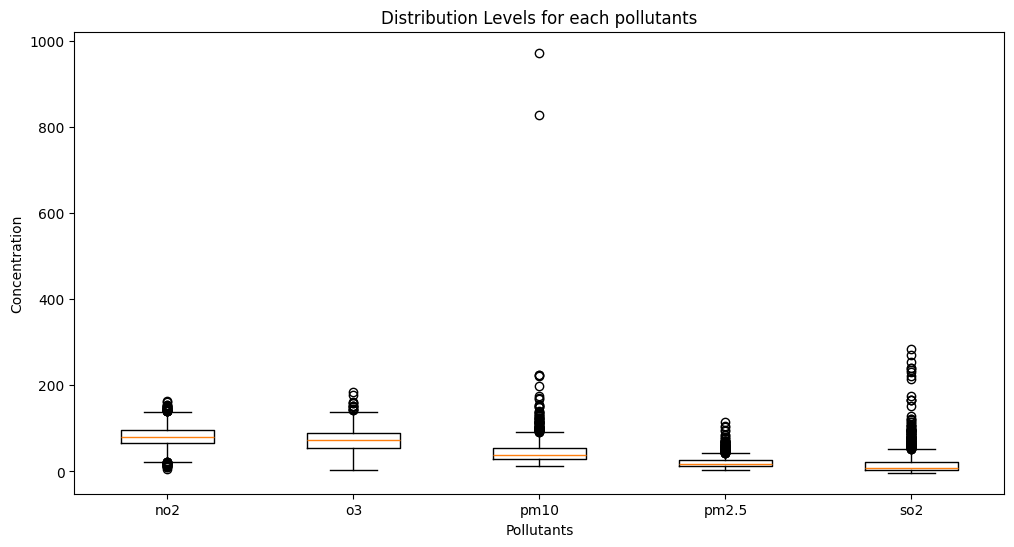

In [32]:
import matplotlib.pyplot as plt

pollutants = ["no2", "o3", "pm10", "pm2.5", "so2"]

plt.figure(figsize=(12, 6))
plt.boxplot([df_metepollu_trainingset[pollutant].dropna() for pollutant in pollutants], tick_labels=pollutants)

plt.title("Distribution Levels for each pollutants")
plt.ylabel("Concentration")
plt.xlabel("Pollutants")
plt.show()


## 9. The RFR done by Alex

In [ ]:

df = pd.read_csv(r"C:\Users\sophi\FrMarques\LyonData WCS new\P3 wildAir\p3_WildAir\Open_Meteo_com\OpenMeteo_data\CSV\df_meteopolluwind2124.csv")  # Certifica-te de que o ficheiro está no diretório correto

df['winddir_sin'] = np.sin(np.radians(df['winddirection_360']))
df['winddir_cos'] = np.cos(np.radians(df['winddirection_360']))
df.drop(columns=['winddirection_360'], inplace=True)

df['PM2.5_lag1'] = df['PM2.5'].shift(1)
df['PM2.5_lag2'] = df['PM2.5'].shift(2)

df.dropna(inplace=True)

features = ['temp_c', 'humidity_%', 'rain_mm', 'atmopressure_hpa', 'cloudcover_%',
            'windspeed_kmh', 'winddir_sin', 'winddir_cos', 'u10', 'O3', 'PM2.5_lag1', 'PM2.5_lag2']
target = 'PM2.5'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, 
    verbose=2, scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Performance by optimized model for PM2.5:")
print(f"    - MAE: {mae:.3f}")
print(f"    - RMSE: {rmse:.3f}")
print(f"    - R²: {r2:.3f}")
print(f" Best hyperparameters: {grid_search.best_params_}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits

 Performance by optimized model for PM2.5:
    - MAE: 6.046
    - RMSE: 8.001
    - R²: 0.602
 Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [101]:
df['date_id'] = pd.to_datetime(df['date_id'])

In [100]:
df.columns

Index(['Unnamed: 0', 'date_id', 'month_num', 'temp_c', 'humidity_%', 'rain_mm',
       'snowfall_cm', 'atmopressure_hpa', 'cloudcover_%', 'windspeed_kmh',
       'NO2', 'O3', 'PM10', 'PM2.5', 'SO2', 'windspeed_ms', 'u10', 'v10',
       'winddir_sin', 'winddir_cos', 'PM2.5_lag1', 'PM2.5_lag2'],
      dtype='object')

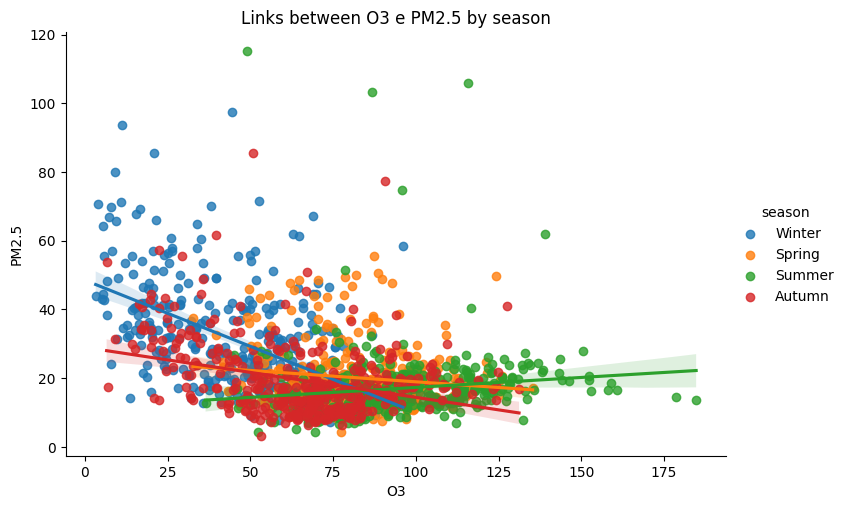

In [104]:
df["season"] = df["date_id"].dt.month.map({12: "Winter", 1: "Winter", 2: "Winter",
                                        3: "Spring", 4: "Spring", 5: "Spring",
                                        6: "Summer", 7: "Summer", 8: "Summer",
                                        9: "Autumn", 10: "Autumn", 11: "Autumn"})

sns.lmplot(data=df, x="O3", y="PM2.5", hue="season", aspect=1.5)
plt.title("Links between O3 e PM2.5 by season")
plt.show()
